# Создание метрики для расчета качества выделения лесных просек

## Импорт библиотек и дополнительные установки

In [1]:
import warnings
import os
from osgeo import gdal
import rioxarray as rxr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from matplotlib.colors import ListedColormap
import seaborn as sns
from scipy.stats import anderson, jarque_bera
from skimage import color

from clearings_extraction_algorithm import ClearingsDetectionMetrics

In [2]:
warnings.filterwarnings("ignore")
gdal.UseExceptions()
gdal.AllRegister()

In [3]:
%matplotlib inline
sns.set_style("ticks")

## Расчет метрик качества выделения лесных просек

Растры содержат информацию о границах лесных просек, к тому же из-за особенности алгоритма у нас отсутствуют маски выделенных просек, поэтому такие широко применяемые метрики как accuracy или IoU не помогут рассчитать качество выделения лесных просек. Для этого разработана новая метрика близости - обратное значение среднего расстояния от пикселей, расположенных под линиями электропередач, до пикселей выделенных границ лесной просеки.

Загрузим результаты выделения лесных просек:

In [4]:
tif_files = [
    os.path.join("results", file)
    for file in os.listdir("results")
    if file.endswith(".tif")
]
results = [rxr.open_rasterio(file).values for file in tif_files]

Переведем их в бинарную одноканальную маску:

In [5]:
for i in range(len(results)):
    results[i] = np.moveaxis(results[i], 0, -1)
    results[i] = results[i][..., :3]
    results[i] = color.rgb2gray(results[i])
    results[i] = (results[i] > 0).astype(np.uint8)

In [6]:
all_images = [
    r".\images\experimental_areas_images\big_areas_images\sentinel2_2020_06_1_2.tif",
    r".\images\experimental_areas_images\big_areas_images\sentinel2_2020_06_2_2.tif",
    r".\images\experimental_areas_images\big_areas_images\sentinel2_2020_06_3_2.tif",
    r".\images\test_images\sentinel2_2017_06_forest.tif",
    r".\images\test_images\sentinel2_2020_06_town.tif",
    r".\images\test_images\sentinel2_2020_07_river.tif",
    r".\images\test_images\sentinel2_2021_06_forest_river.tif",
    r".\images\test_images\sentinel2_2016_06_bare_lands.tif",
    r".\images\test_images\sentinel2_2021_06_roads.tif",
]

In [7]:
power_lines_vectors_paths = [
    f"./power_lines/vectors/{file}"
    for file in os.listdir("./power_lines/vectors/")
    if file.endswith(".shp")
]
rasterized_lines_paths = [
    f"./power_lines/rasters/{file[:-4]}.tif"
    for file in os.listdir("./power_lines/vectors/")
    if file.endswith(".shp")
]

area_nums = [1, 2, 3, 5, 6, 7, 8, 9]

closeness_stats = pd.DataFrame(columns=["Близость"], index=area_nums)
closeness_stats.index.name = "Номер участка"

all_images.remove(r".\images\test_images\sentinel2_2017_06_forest.tif")
deleted_result = results.pop(3)

Рассчитаем значения метрики близости. Метрика близости показывает среднюю удаленность выделенных границ просек от ЛЭП. Для расчета этой метрики необходимо:
1) Растеризовать векторный слой линий электропередач
2) Рассчитать матрицу евклидового расстояния от пикселей, принадлежащих к ЛЭП, до остальных пикселей участка
3) Маскировать матрицу расстояний выделенными границами лесных просек
4) Рассчитать медиану значения расстояния в пикселях и перевод в метры (1 пиксель изображения Sentinel имеет пространственное разрешение 10 метров)
5) Рассчитать обратное значение получившегося на шаге 4 показателя


In [8]:
for (
    power_lines,
    reference_raster,
    rasterized_line_path,
    clearings_mask,
    area_num,
) in zip(
    power_lines_vectors_paths,
    all_images,
    rasterized_lines_paths,
    results,
    area_nums,
):
    detection_metric = ClearingsDetectionMetrics(clearings_mask)
    ClearingsDetectionMetrics.rasterize_vector(
        power_lines, reference_raster, rasterized_line_path
    )
    detection_metric.calculate_closeness_value(rasterized_line_path)
    closeness_stats.loc[area_num] = detection_metric.closeness_value

In [9]:
closeness_stats

,Близость
Номер участка,
1,0.354
2,0.017
3,0.002
5,0.158
6,0.013
7,0.029
8,0.354
9,0.002


Проведем статистические тесты Андерсона-Дарлинга и Жарка-Бера для проверки распределений значений маскированных расстояний на нормальность:

In [10]:
distances = []

for (rasterized_line_path, clearings_mask) in zip (rasterized_lines_paths, results):
    raster = rxr.open_rasterio(rasterized_line_path)
    raster_line = np.zeros((raster.shape[1], raster.shape[2]), dtype=np.uint8)
    raster_line = np.array(raster[0, :, :])
    dist_m = ClearingsDetectionMetrics.calculate_distance_matrix(raster_line)
    masked_distances = dist_m * clearings_mask
    masked_zeros_distances = np.ma.masked_equal(masked_distances, 0).flatten()
    masked_zeros_distances = masked_zeros_distances.compressed()
    distances.append(masked_zeros_distances)

In [11]:
for i in range(len(distances)):
    result = anderson(distances[i], dist='norm')
    if i >= 3:
        print('Участок '+ str(i + 2) + ":")
    else:
        print('Участок '+ str(i + 1) + ":")
    print(f"Тест Андерсона-Дарлинга: {round(result.statistic, 1)}, {round(result.critical_values[-1], 1)}")
    stat, p = jarque_bera(distances[i])
    print(f"Тест Жарка-Бера: {round(stat, 1)}, {round(p, 1)}")

Участок 1:
Тест Андерсона-Дарлинга: 3806.7, 1.1
Тест Жарка-Бера: 786657.5, 0.0
Участок 2:
Тест Андерсона-Дарлинга: 3656.8, 1.1
Тест Жарка-Бера: 5655.9, 0.0
Участок 3:
Тест Андерсона-Дарлинга: 23.0, 1.1
Тест Жарка-Бера: 82.4, 0.0
Участок 5:
Тест Андерсона-Дарлинга: 6941.8, 1.1
Тест Жарка-Бера: 21241.2, 0.0
Участок 6:
Тест Андерсона-Дарлинга: 2881.8, 1.1
Тест Жарка-Бера: 3638.8, 0.0
Участок 7:
Тест Андерсона-Дарлинга: 1519.2, 1.1
Тест Жарка-Бера: 7193.0, 0.0
Участок 8:
Тест Андерсона-Дарлинга: 2162.6, 1.1
Тест Жарка-Бера: 2898.1, 0.0
Участок 9:
Тест Андерсона-Дарлинга: 6702.3, 1.1
Тест Жарка-Бера: 27111.0, 0.0


Все тесты отклонили гипотезу о нормальности распределения, поэтому в качестве меры центральности для расчета метрики близости выбрана медиана, более устойчивая к распределениям, отклоняющихся от нормального.

У метрики близости есть один недостаток - она дает хороший результат не только в случае, когда границы просек выделились на всей ее протяженности, но и когда присутствуют пробелы в выделенной маске. 

Поэтому помимо метрики близости разработана метрика непрерывности. Метрика непрерывности выделения границ лесных просек показывает меру того, насколько непрерывно выделены лесные просеки на всей их протяженности. 

In [12]:
power_towers_vector_paths = [
    f"./power_towers/{file}"
    for file in os.listdir("./power_towers/")
    if file.endswith(".shp")
]
lst_reduced_vector_power_towers = os.listdir("./power_towers/reduced")
reduced_vector_power_tower_paths = [
    f"./power_towers/reduced/{file}"
    for file in os.listdir("./power_towers/")
    if file.endswith(".shp")
]
rasterized_towers_paths = [
    f"./power_towers/rasters/{file[:-4]}.tif"
    for file in os.listdir("./power_towers/")
    if file.endswith(".shp")
]

area_nums = [1, 2, 3, 5, 6, 8]

all_images.remove(r".\images\test_images\sentinel2_2021_06_roads.tif")
results.pop(-1)
all_images.remove(r".\images\test_images\sentinel2_2021_06_forest_river.tif")
results.pop(5)

integrity_stats = pd.DataFrame(columns=["Непрерывность"], index=area_nums)
integrity_stats.index.name = "Номер участка"

Как и в случае с метрикой близости проводится растеризация векторного слоя, но не ЛЭП, а их пилонов в виде точек. Перед растеризацией точечный слой пилонов подвергается операции исключения дублей и неинформативных вертексов векторного слоя пилонов ЛЭП, в результате чего сокращенный слой не теряет пространственную репрезентативность. С растеризованным слоем производится итерация по пилонам ЛЭП – для каждого пилона вычисляется матрица расстояний, затем матрица маскируется и находится минимальное значение расстояния среди немаскированных значений. Вычисляется среднее минимальных расстояний путем суммирования минимальных расстояний и деления суммы на число пилонов.

In [13]:
for (
    power_towers,
    reduced_power_towers,
    raster_towers_path,
    reference_raster,
    clearings_mask,
    area_num,
) in zip(
    power_towers_vector_paths,
    reduced_vector_power_tower_paths,
    rasterized_towers_paths,
    all_images,
    results,
    area_nums,
):
    detection_metric = ClearingsDetectionMetrics(clearings_mask)
    ClearingsDetectionMetrics.reduce_power_towers_density(
        power_towers, reduced_power_towers
    )
    ClearingsDetectionMetrics.rasterize_vector(
        reduced_power_towers, reference_raster, raster_towers_path
    )
    detection_metric.calculate_integrity_value(raster_towers_path)
    integrity_stats.loc[area_num] = detection_metric.integrity_value

In [14]:
integrity_stats

,Непрерывность
Номер участка,
1,0.014
2,0.025
3,0.002
5,0.022
6,0.044
8,0.021


## Визуализация результатов расчета метрик

Отобразим визуально некоторые шаги по расчету метрики близости. На графике ниже представлен хороший пример, при котором границы лесных просек расположены там, где действительно они находятся. Здесь ожидается высокое значение метрики близости.

In [15]:
single_color = ListedColormap(["#696969"])
letters = ["а", "б", "в"]
plt.rcParams.update({"font.size": 16})

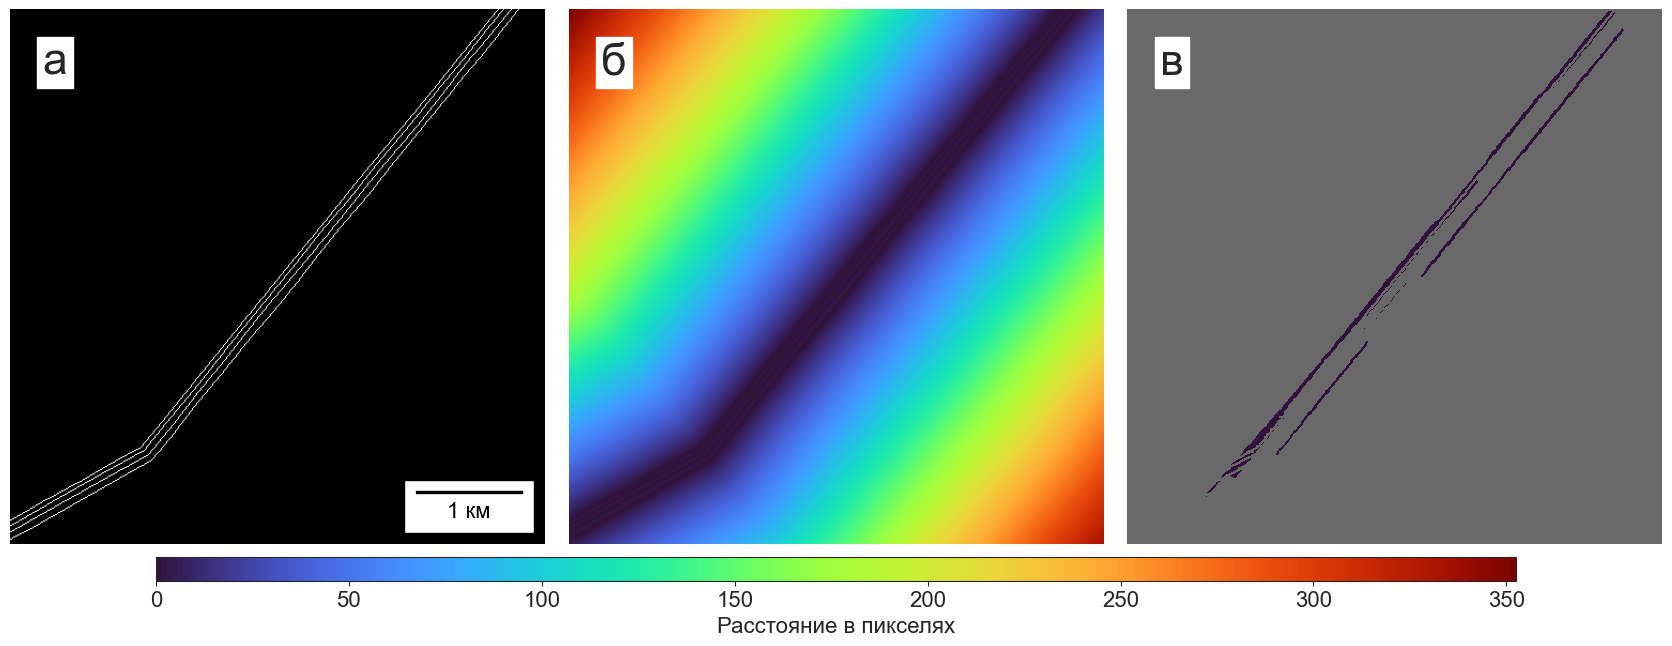

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(17, 8))
axes = axes.ravel()

detection_metric = ClearingsDetectionMetrics(results[0])
detection_metric.open_raster("./power_lines/rasters/power_lines_1.tif")
axes[0].imshow(detection_metric.locations[500:1000, 400:900], cmap="gray")

scalebar = AnchoredSizeBar(
    axes[0].transData,
    100,
    "1 км",
    "lower right",
    sep=6,
    pad=0.5,
    borderpad=0.5,
    color="black",
    bbox_transform=axes[0].transAxes,
    size_vertical=2,
)
scalebar.set_clip_on(False)
axes[0].add_artist(scalebar)
distance_matrix = detection_metric.calculate_distance_matrix(detection_metric.locations)
dist_m = axes[1].imshow(distance_matrix[500:1000, 400:900], cmap="turbo")

masked_zeros_distances = detection_metric.mask_distances(distance_matrix)
vmin, vmax = distance_matrix.min(), distance_matrix.max()
axes[2].imshow((distance_matrix * 0)[500:1000, 400:900], cmap=single_color)
axes[2].imshow(
    masked_zeros_distances[500:1000, 400:900], cmap="turbo", vmin=vmin, vmax=vmax
)

for i in range(3):
    axes[i].axis("off")
cbar_ax = fig.add_axes([0.1, 0.12, 0.8, 0.03])
cbar = fig.colorbar(dist_m, cax=cbar_ax, orientation="horizontal")
cbar.set_label("Расстояние в пикселях")
axes[0].text(30, 60, letters[0], bbox=dict(facecolor="white"), fontsize=32)
axes[1].text(30, 60, letters[1], bbox=dict(facecolor="white"), fontsize=32)
axes[2].text(30, 60, letters[2], bbox=dict(facecolor="white"), fontsize=32)

plt.tight_layout()
file_name = "metrics_calc_steps_1.svg"
file_path = os.path.join("svg_plots", file_name)
fig.savefig(file_path, format="svg", dpi=300, bbox_inches="tight")
plt.show()

Следующий график показывает плохой пример, при котором достаточно много линий - границ лесных просек оказалось за пределами действительной лесной просеки. Здесь ожидается низкое значение метрики близости

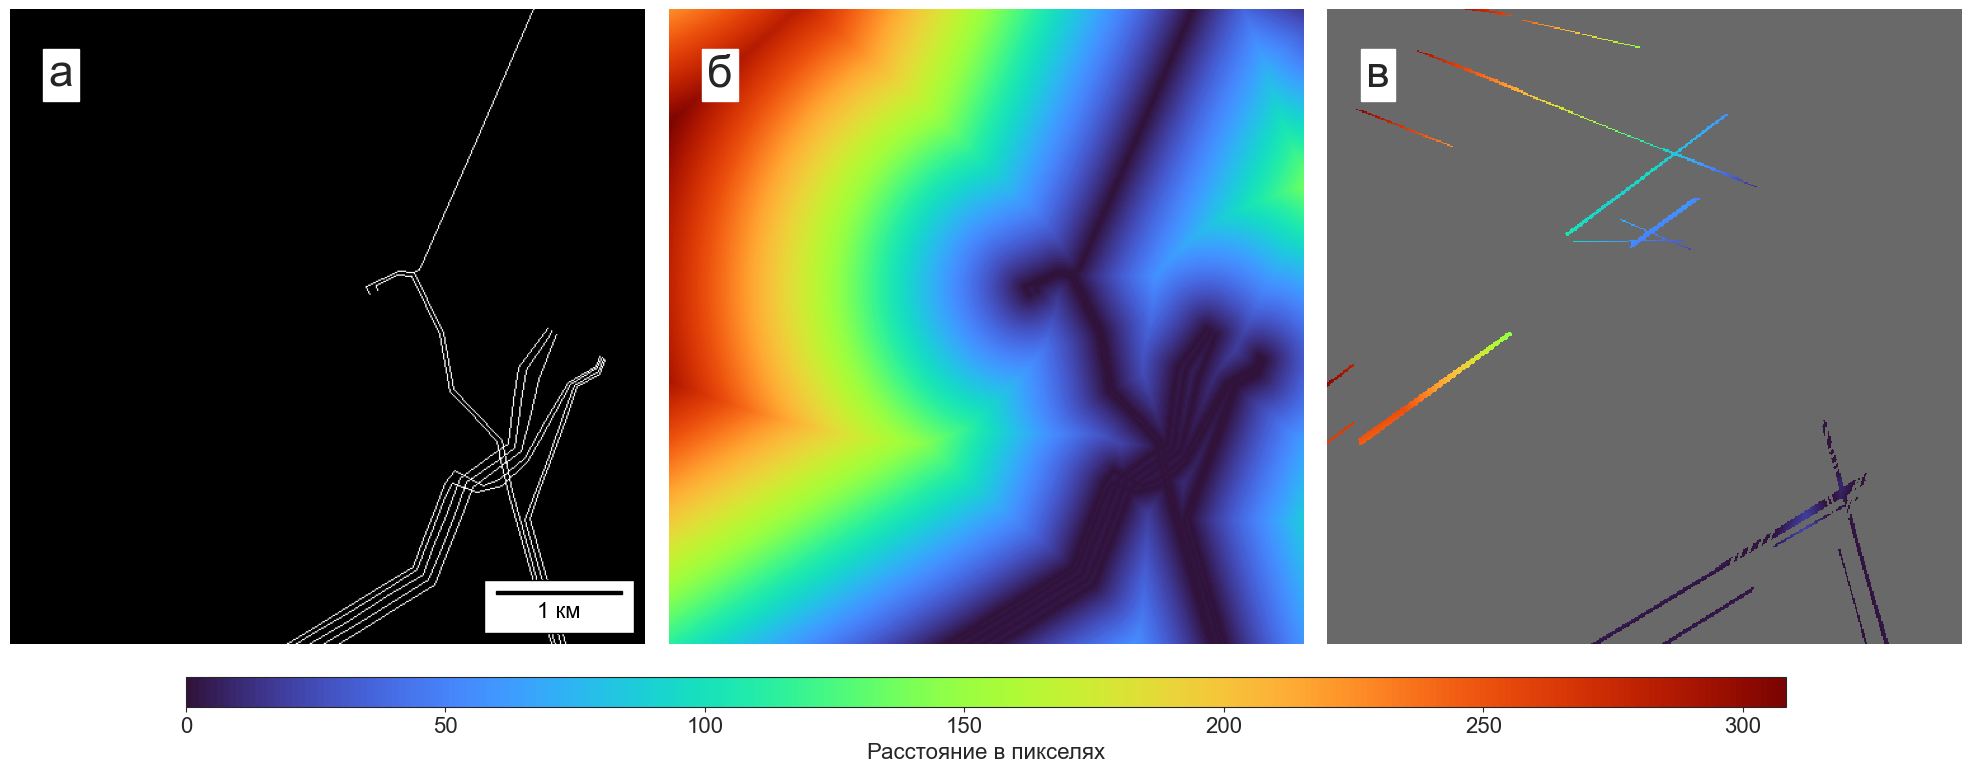

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))
axes = axes.ravel()

detection_metric = ClearingsDetectionMetrics(results[1])
detection_metric.open_raster("./power_lines/rasters/power_lines_2.tif")
axes[0].imshow(detection_metric.locations[300:800, 1200:1700], cmap="gray")

scalebar = AnchoredSizeBar(
    axes[0].transData,
    100,
    "1 км",
    "lower right",
    sep=6,
    pad=0.5,
    borderpad=0.5,
    color="black",
    bbox_transform=axes[0].transAxes,
    size_vertical=2,
)
scalebar.set_clip_on(False)
axes[0].add_artist(scalebar)
distance_matrix = detection_metric.calculate_distance_matrix(detection_metric.locations)
dist_m = axes[1].imshow(distance_matrix[300:800, 1200:1700], cmap="turbo")

masked_zeros_distances = detection_metric.mask_distances(distance_matrix)
axes[2].imshow((distance_matrix * 0)[300:800, 1200:1700], cmap=single_color)
axes[2].imshow(masked_zeros_distances[300:800, 1200:1700], cmap="turbo")

for i in range(3):
    axes[i].axis("off")
cbar_ax = fig.add_axes([0.1, 0.12, 0.8, 0.03])
cbar = fig.colorbar(dist_m, cax=cbar_ax, orientation="horizontal")
cbar.set_label("Расстояние в пикселях")
axes[0].text(30, 60, letters[0], bbox=dict(facecolor="white"), fontsize=32)
axes[1].text(30, 60, letters[1], bbox=dict(facecolor="white"), fontsize=32)
axes[2].text(30, 60, letters[2], bbox=dict(facecolor="white"), fontsize=32)

plt.tight_layout()
file_name = "metrics_calc_steps_2.svg"
file_path = os.path.join("svg_plots", file_name)
fig.savefig(file_path, format="svg", dpi=300, bbox_inches="tight")
plt.show()

Отобразим визуально некоторые шаги по расчету метрики непрерывности:

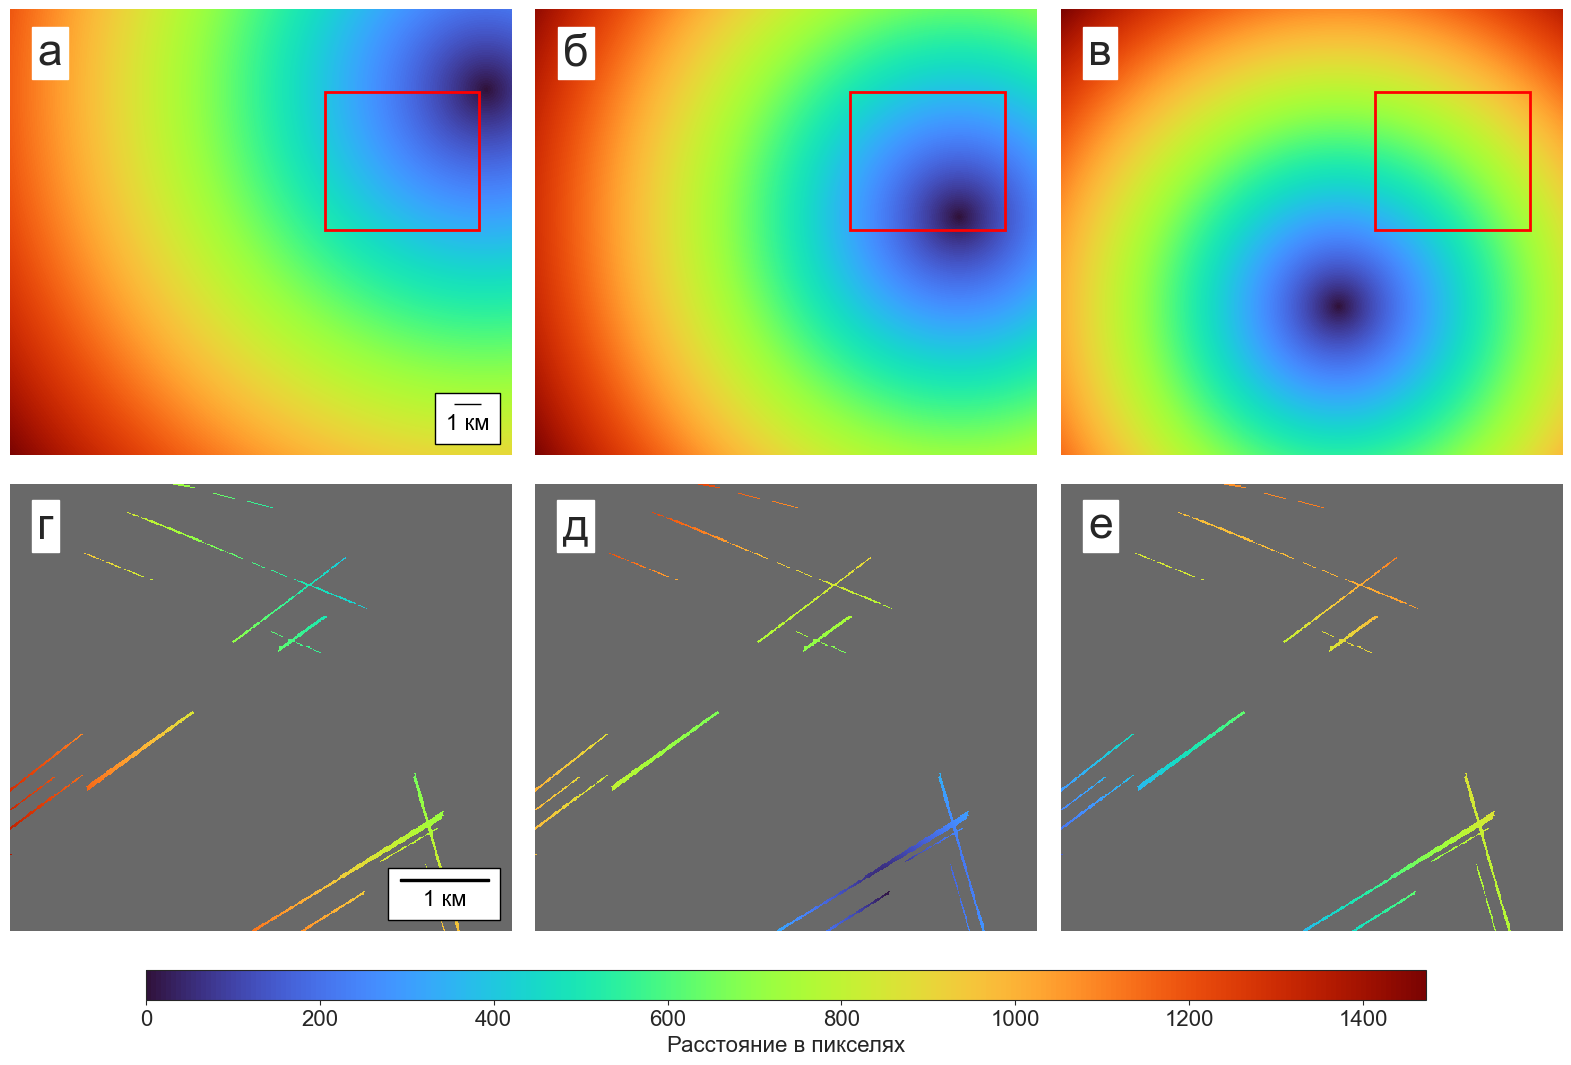

In [18]:
letters = ["а", "б", "в", "г", "д", "е"]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 10))
axes = axes.ravel()

detection_metric = ClearingsDetectionMetrics(results[1])
detection_metric.open_raster("./power_towers/rasters/power_towers_2.tif")
points_arrays = detection_metric.split_points_into_arrays()
tower_indexes = [0, 4, 8]
for index_plot, tower_index in enumerate(tower_indexes):
    distance_matrix = detection_metric.calculate_distance_matrix(
        points_arrays[tower_index]
    )
    dist_m = axes[index_plot].imshow(distance_matrix, cmap="turbo")
    vmin, vmax = distance_matrix.min(), distance_matrix.max()
    masked_zeros_distances = detection_metric.mask_distances(distance_matrix)
    rectangle = patches.Rectangle(
        (1140, 300), 560, 500, linewidth=2, edgecolor="red", facecolor="none"
    )
    axes[index_plot].add_patch(rectangle)
    axes[index_plot].axis("off")
    axes[index_plot + 3].imshow(
        (distance_matrix * 0)[300:800, 1140:1700],
        cmap=single_color,
        vmin=vmin,
        vmax=vmax,
    )
    axes[index_plot + 3].imshow(
        masked_zeros_distances[300:800, 1140:1700],
        cmap="turbo",
        vmin=np.min(distance_matrix[300:800, 1140:1700]),
        vmax=np.max(distance_matrix[300:800, 1140:1700]),
    )
    axes[index_plot + 3].axis("off")

scalebar_0 = AnchoredSizeBar(
    axes[0].transData,
    100,
    "1 км",
    "lower right",
    sep=6,
    pad=0.5,
    borderpad=0.5,
    color="black",
    bbox_transform=axes[0].transAxes,
    size_vertical=2,
)
scalebar_0.set_clip_on(False)
axes[0].add_artist(scalebar_0)

scalebar_3 = AnchoredSizeBar(
    axes[3].transData,
    100,
    "1 км",
    "lower right",
    sep=6,
    pad=0.5,
    borderpad=0.5,
    color="black",
    bbox_transform=axes[3].transAxes,
    size_vertical=2,
)
scalebar_3.set_clip_on(False)
axes[3].add_artist(scalebar_3)

cbar_ax = fig.add_axes([0.1, -0.03, 0.8, 0.03])
cbar = fig.colorbar(dist_m, cax=cbar_ax, orientation="horizontal")
cbar.set_label("Расстояние в пикселях")
axes[0].text(100, 200, letters[0], bbox=dict(facecolor="white"), fontsize=32)
axes[1].text(100, 200, letters[1], bbox=dict(facecolor="white"), fontsize=32)
axes[2].text(100, 200, letters[2], bbox=dict(facecolor="white"), fontsize=32)
axes[3].text(30, 60, letters[3], bbox=dict(facecolor="white"), fontsize=32)
axes[4].text(30, 60, letters[4], bbox=dict(facecolor="white"), fontsize=32)
axes[5].text(30, 60, letters[5], bbox=dict(facecolor="white"), fontsize=32)

plt.tight_layout()
file_name = "metrics_calc_steps_towers.svg"
file_path = os.path.join("svg_plots", file_name)
fig.savefig(file_path, format="svg", dpi=300, bbox_inches="tight")
plt.show()